In [ ]:
import sys
import logging
import os
import math
import json
from tqdm import tqdm
import warnings
from IPython.display import display, Audio

import numpy as np
import librosa

import torch

import scdata

sys.path.append('..')
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

from aural_travels.data import soundcloud
from aural_travels.train import visualizer

MODEL_DIR = '/home/leo/src/aural-travels/models/nat_vqgan_layers16'
DATA_DIR = '/home/leo/src/scdata'

In [ ]:
with open(os.path.join(MODEL_DIR, 'params.json')) as f:
    params = json.load(f)
    
params

In [ ]:
#split = 'training'
split = 'validation'

dataset = visualizer.load_dataset(params,
                                  split,
                                  torch.load(f'../models/encoding/{params["image_repr"]}/{split}.pt'))
image_repr = visualizer.create_image_repr(params)
model = visualizer.create_model(params, image_repr, dataset)
model.eval().to('cuda')

checkpoint = torch.load(os.path.join(MODEL_DIR, 'last_checkpoint.pt'))
model.load_state_dict(checkpoint['model'])

checkpoint['global_step']

In [ ]:
def show(image_seq, save=None):
    image = image_repr.tensor_to_image(image_repr.decode(image_seq)[0])
    display(image)
    if save:
        image.save(save)
    return image

corrupt_image_seq = image_repr.rand_image_seq(1, device='cuda')
show(corrupt_image_seq)

corrupt_image_seq = image_repr.rand_image_seq(1, device='cuda', patch_size=4)
show(corrupt_image_seq)

corrupt_image_seq = image_repr.zeros_image_seq(1, device='cuda')
show(corrupt_image_seq)

print('')

In [ ]:
top_k = 0
temperature = 1

indices = list(range(3))

for idx in indices:
    track = dataset.tracks[idx]
    print(f'{track["genre"]}: {track["title"]} ({track["id"]})')
    
    audio, ref_image_seq = dataset[idx]
    
    audio = audio[None, ...].to('cuda')
    ref_image_seq = ref_image_seq[None, ...].to('cuda')

    print('ref')
    show(ref_image_seq)
    
#     print('from_zeros')
#     image_seq = model.generate_image_seq(audio,
#                                          top_k=top_k,
#                                          temperature=temperature,
#                                          corrupt_image_seq=image_repr.zeros_image_seq(1, device='cuda'))
#    show(image_seq)
    
    for i in range(1):
        print('from_rand')
        image_seq = model.generate_image_seq(audio,
                                             top_k=top_k,
                                             temperature=temperature,
                                             corrupt_image_seq=image_repr.rand_image_seq(1, patch_size=4, device='cuda'))
        print((image_seq == ref_image_seq).sum())
        show(image_seq)
        
    print('from_corrupt')
    corrupt_image_seq = visualizer.corrupt_image_seq('uniform',
                                                     image_repr.vocab_size(),
                                                     ref_image_seq[0].clone())[None, ...]
    image_seq = model.generate_image_seq(audio,
                                         top_k=top_k,
                                         temperature=temperature,
                                         corrupt_image_seq=corrupt_image_seq)
    print((corrupt_image_seq == ref_image_seq).sum())
    print((image_seq == ref_image_seq).sum())
    show(image_seq)
    
    print('corrupt')
    show(corrupt_image_seq)

In [ ]:
from IPython.display import Audio

track_idx = 5
path = scdata.get_audio_path(os.path.join(DATA_DIR, 'audio'), dataset.tracks[track_idx]['id'])
print(path)
Audio(path)

In [ ]:
mel = torch.tensor(dataset.load_features(track_idx), dtype=torch.float)
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv
print(mel.shape)
print(mel.shape[0] / 21)

In [ ]:
import msaf

boundaries, labels = msaf.process(path)

In [ ]:
boundaries

In [ ]:
labels

In [ ]:
dataset.tracks[4]

In [ ]:
from IPython.display import clear_output

from librosa.onset import onset_strength
from librosa.beat import beat_track

from aural_travels import generate

frames_dir = os.path.join(MODEL_DIR, 'gen', 'frames') 
os.makedirs(frames_dir, exist_ok=True)

track_idx = 5
last_image_seq = image_repr.rand_image_seq(1, device='cuda', patch_size=2)

mel = torch.tensor(dataset.load_features(track_idx), dtype=torch.float)
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv

path = scdata.get_audio_path(os.path.join(DATA_DIR, 'audio'), dataset.tracks[track_idx]['id'])
y, _ = librosa.load(path, sr=dataset.sample_rate, mono=True)
onset_env = onset_strength(y, sr=dataset.sample_rate)
onset_env_filtered = gaussian_filter1d(onset_env, 4)

bpm, beats = beat_track(y, sr=dataset.sample_rate, units='time')

def noise(time, next_time, image_seq):
    generate.onset_env_noise(image_repr=model.image_repr,
                             onset_env=onset_env_filtered,
                             time=time,
                             next_time=next_time,
                             image_seq=image_seq,
                             power=2,
                             scale=5)
    generate.beat_cross_noise(image_repr=model.image_repr,
                              beats=beats,
                              time=time,
                              next_time=next_time,
                              image_seq=image_seq)
    generate.segment_reset_noise(image_repr=model.image_repr,
                                 boundaries=boundaries,
                                 time=time,
                                 next_time=next_time,
                                 image_seq=image_seq)

keyframes = generate.keyframes(model=model,
                               mel=mel,
                               last_image_seq=last_image_seq,
                               fps=10.0,
                               noise=noise,
                               temperature=1.5,
                               device='cuda')

frames = generate.interpolate(image_repr=image_repr,
                              keyframes=keyframes,
                              interframes=6)

for i, frame in enumerate(frames):
    image = image_repr.tensor_to_image(frame)
    if i % 100 == 0:
        clear_output(wait=True)
        display(image)
    image.save(os.path.join(frames_dir, f'{i}.png'))

[0.         0.         0.         0.00267482 0.         0.
 0.         0.03313705 0.10618851 0.16116807 0.21548022 0.06335737
 0.07878926 0.10354544 0.21127142 0.26687267 0.11507119 0.1187228
 0.25168884 0.45439178 0.22872822 0.19928469 0.19142392 0.3556699
 0.49148345 0.32816008 0.12836924 0.2351946  0.48781055 0.32633144
 0.32436603 0.20274445 0.22708917 0.44066554 0.38179997 0.32027978
 0.26312643 0.3483441  0.43065614 0.6051022  0.68713343 0.615296
 0.6285589  0.51973224 0.78583175 0.55780137 0.72771597 0.7555704
 0.7818377  0.8933388  0.59603983 0.5645575  0.72385144 0.6703564
 0.610744   0.7437511  0.67604685 0.6479063  0.6431945  0.9982098
 0.8432612  0.72406244 0.5127436  0.77673113 0.84965885 0.55373335
 0.5830445  0.67245877 0.6840786  0.98930955 0.805929   0.73983127
 1.1802603  0.86637545 0.6148633  0.5864084  1.3029604  0.70359385
 0.65996015 1.0712707  1.0255353  0.9900638  0.86460364 0.8304735
 0.5431253  0.81604934 0.9322337  1.1551105  0.6884817  0.7561256
 0.9968817  

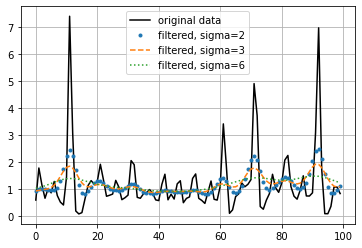

In [31]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

print(onset_env[:100])
print(gaussian_filter1d(onset_env, 3)[:100])

t1=1000
t2=1100
plt.plot(onset_env[t1:t2], 'k', label='original data')
plt.plot(gaussian_filter1d(onset_env, 2)[t1:t2], '.', label='filtered, sigma=2')
plt.plot(gaussian_filter1d(onset_env, 3)[t1:t2], '--', label='filtered, sigma=3')
plt.plot(gaussian_filter1d(onset_env, 6)[t1:t2], ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif(os.path.join(frames_dir, 'out.gif'))

In [ ]:
from IPython.display import Video
Video(os.path.join(frames_dir, 'out.mp4'), embed=True)